In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(context='notebook')
import numpy as np
import pandas as pd
np.random.seed(3116)
import warnings
warnings.filterwarnings('ignore')


In [40]:
colNames = ['parents',
'has_nurs',
'form',
'children',
'housing',
'finance',
'social',
'health', 
'Nursery']

df = pd.read_csv('nursery.data', sep=',', names=colNames)
df.columns
targetCol = 8
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,Nursery
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [41]:
df['Nursery'].unique()

array(['recommend', 'priority', 'not_recom', 'very_recom', 'spec_prior'],
      dtype=object)

In [42]:
def split_dataset(dataset, train_size = 0.7, validation_size = 0.15, test_size = 0.15):
    """This function takes in a dataset, and three size parameters for train, 
    validation, and test sets (with default values of 0.7, 0.15, and 0.15 respectively). The function 
    first determines the total number of rows in the dataset, then shuffles it using the "sample" 
    method and resets the index. It then uses the "sample" method again to create a training set, 
    removing those rows from the dataset. It creates a validation set by taking the next specified 
    percentage of rows, and removes those from the dataset as well. The remaining rows are then copied 
    to create the test set. Finally, all three sets are converted to numpy arrays and returned. The 
    function is then called with the variable "df" as the input dataset, and the returned sets are 
    assigned to "train_df", "val_df", and "test_df" respectively."""
    total_rows = len(dataset)
    dataset = dataset.sample(frac = 1).reset_index(drop=True)
    train_set = dataset.sample(frac = train_size)
    dataset = dataset.drop(train_set.index)
    validation_set = dataset[:int(validation_size * total_rows)]
    dataset = dataset.drop(validation_set.index)
    test_set = dataset.copy()
    train_set = train_set.to_numpy()
    validation_set = validation_set.to_numpy()
    test_set = test_set.to_numpy()
    return train_set, validation_set, test_set

train_df, val_df, test_df = split_dataset(df)

In [43]:
class splitCondition:
    def __init__(self, colName, column, value):
        """
        Initializes the class with the column name, column index and the value used for splitting the dataset
        :param colName: name of the column
        :param column: index of the column
        :param value: value used for splitting the dataset
        """
        self.colName = colName
        self.column = column
        self.value = value
        self.numercial = isinstance(self.value, float)

    def evaluate(self, row):
        """
        This method checks if the value of the current row is less than or equal to the provided value
        :param row: current row of the dataset
        :return: boolean value indicating if the row satisfies the condition
        """
        value = row[self.column]
        if isinstance(value, int) or isinstance(value, float):
            return value <= self.value
        return value == self.value

    def split(self, dfset):
        """
        This method splits the dataset based on the provided condition
        :param dfset: dataset to be split
        :return: left and right partitions of the dataset
        """
        left_partition, right_partition = [], []
        for row in dfset:
            if self.evaluate(row):
                left_partition.append(row)
            else:
                right_partition.append(row)
        return np.array(left_partition), np.array(right_partition)
    
    def to_string(self):
        check_condition = '<=' if self.numercial else '=='
        return 'check for {} {} {}'.format(self.colName, check_condition, self.value)

In [44]:
def crossEntropy(dfset, targetCol):
    """
    Compute cross entropy loss for a given dataset and target column
    :param dfset: input dataset
    :param targetCol: target column
    :return: cross entropy loss
    """
    entropy = 0
    unique, count= np.unique(dfset[:,targetCol], return_counts=True)
    for index, _ in enumerate(unique):
        pt = count[index] / len(dfset)
        entropy += (pt * np.log2(pt))
    return -1 * entropy

In [45]:
def dominantClass(dfset, targetCol):
    """
    This function takes in a dataset and the target column of the dataset
     as input and returns the number of occurrences of the dominant class
    in the target column. The dominant class is the class with the highest
    count in the target column.
    """
    target = dfset[:,targetCol]
    unique, counts = np.unique(target, return_counts=True)
    dominantClass = unique[np.argmax(counts)]
    return (target == dominantClass).sum()

In [46]:
def MCR(dfset, targetCol, obj):
    """The function MCRdfset, targetCol, obj takes in three parameters 
    1. dfset A dataset which is a dataframe 
    2. targetCol The target column of the dataset which is a string 
    3. obj An object of a class that has the split method The function first uses the split method 
    of the obj class to split the dataset into two parts leftdf and rightdf. It then checks
     if either of the left or right dataframes are empty, if so it returns 1.
    """
    left_df, right_df = obj.split(dfset)
    if len(left_df) == 0 or len(right_df) == 0:
        return 1
    numLeftDoms = dominantClass(left_df, targetCol)
    numRightDoms = dominantClass(right_df, targetCol)
    return ((len(left_df) - numLeftDoms) + (len(right_df) - numRightDoms)) / len(dfset)

In [47]:
def informationGain(dataset, left_dataset, right_dataset, targetCol):
    """This function calculates the information gain by subtracting 
    the weighted average entropy of the left and right sub-datasets 
    from the entropy of the original dataset, using the target column 
    as the class variable."""
    crossEntropy_dataset = crossEntropy(dataset, targetCol)
    crossEntropy_left_dataset = crossEntropy(left_dataset, targetCol)
    crossEntropy_right_dataset = crossEntropy(right_dataset, targetCol)
    weightLeft = len(left_dataset) / len(dataset)
    weightRight = len(right_dataset) / len(dataset)
    return crossEntropy_dataset - (weightLeft * crossEntropy_left_dataset + weightRight * crossEntropy_right_dataset)

In [48]:
def bestFitCrit(dfset, headers, targetCol, crit):
    """This function finds the best fit criteria for the given dataset and target column, 
    either by minimizing the misclassification rate (MCR) or maximizing the information gain. 
    It iterates through all columns of the dataset and for each unique value in the column, 
    it creates a split condition object. Then, it uses the MCR or informationGain function to
     calculate the MCR or information gain of the split. It keeps track of the best split object and 
     its corresponding MCR or information gain, and returns that at the end. The criteria to be used is
      determined by the 'crit' parameter, which can take in either 'mcr' or 'gain'."""
    if crit == 'mcr':
        bestMcr = 1
        bestSObj = None
        for i in range(len(dfset[0])):
            if i == targetCol:
                continue
            unique = np.unique(dfset[:,i])
            if isinstance(unique[0], int) or isinstance(unique[0], float):
                unique = np.mean(unique[:-1], unique[1:])
            
            for unique_val in unique:
                obj = splitCondition(headers[i], i, unique_val)
                mcr = MCR(dfset, targetCol, obj)
                if mcr <= bestMcr:
                    bestMcr = mcr
                    bestSObj = obj
        return bestMcr, bestSObj

    elif crit == 'gain':
        bestGain = 0
        bestSObj = None
        for i in range(len(dfset[0])):
            if i == targetCol:
                continue
            unique = np.unique(dfset[:,i])
            if isinstance(unique[0], int) or isinstance(unique[0], float):
                unique = np.mean(unique[:-1], unique[1:])
            for unique_val in unique:
                obj = splitCondition(headers[i], i, unique_val)
                left_df , right_df = obj.split(dfset)
                left_df=np.array(left_df)
                right_df = np.array(right_df)
                gain = informationGain(dfset, left_df, right_df, targetCol)

                if gain >= bestGain:
                    bestGain = gain
                    bestSObj = obj     
        return bestGain, bestSObj

In [49]:
class Node:
    """This is a class for a node in a decision tree. It has several attributes:
    obj: an object representing the split condition for the node.
    leftNode: a reference to the left child node in the tree.
    rightNode: a reference to the right child node in the tree.
    isLeaf: a boolean indicating whether the current node is a leaf node or not.
    leafClass: the class label for the leaf node, if it's a leaf node.
    It is initialized with the given attributes, with the 'obj' attribute being the split condition of
    the node, 'leftNode' and 'rightNode' representing the left and right child nodes, 'isLeaf' indicating
    whether it is a leaf node or not, and 'leafClass' representing the class label of the leaf node if it
    is a leaf node."""
    def __init__(self, obj, leftNode, rightNode, isLeaf, leafClass):
        self.obj = obj
        self.isLeaf = isLeaf
        self.leafClass = leafClass
        self.leftNode = leftNode
        self.rightNode = rightNode
        

In [50]:
def computeImpurity(dataset, targetCol):
    """This function computes the impurity of a given dataset using Gini impurity.
    It takes in two arguments:
    dataset: the data set to compute impurity of.
    targetCol: the index of the column of the target variable.
    It first finds the unique values of the target column and their corresponding counts in the dataset.
    Then it calculates the probability of each class by dividing the counts by the total number of examples in the dataset.
    Then it calculates the Gini impurity by subtracting the sum of the square of the probabilities from 1.
    Finally it returns the impurity.
    Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled 
    if it were randomly labeled according to the distribution of labels in the dataset. The lower the Gini impurity, 
    the more homogeneous the set."""
    # Counting the number of instances for each class
    _, counts = np.unique(dataset[:, targetCol], return_counts=True)
    # Calculating the probability of each class
    probabilities = counts / len(dataset)
    # Calculating Gini impurity
    impurity = 1 - np.sum(np.square(probabilities))
    return impurity


In [51]:
def treePrint(root):
    """This function is for printing the decision tree. It takes in one argument:
    root: The root node of the decision tree.
    It first checks if the current node is a leaf node, if so, it prints "Leaf Node: " followed by the leaf class label.
    Otherwise, it prints the split condition of the current node by calling the to_string method on the obj attribute of 
    the current node.Then, it recursively calls itself on the left child node by passing the leftNode attribute of the 
    current node as the root, and then on the right child node by passing the rightNode attribute of the current node as 
    the root.It will print the tree in a readable format, each level of the tree corresponding to a new line, and the leaf 
    nodes indicating the class label of the data."""
    if root.isLeaf:
        print('' + 'Leaf Node: ' + str(root.leafClass))
        return
    print('' + root.obj.to_string())
    print('' + 'True: ')
    treePrint(root.leftNode)
    print('' + 'False: ')
    treePrint(root.rightNode)

In [52]:
def decisionTreeLearn(dfset, headers, targetCol, evaluation_metric = 'mcr', iDepth = 2, impurity_threshold = 0.2, min_gain = 0.01):
    """This function is used to generate a decision tree model from a given dataset 
    and column headers. It uses either a misclassification rate (mcr) or information gain 
    (gain) as the evaluation metric to determine the best split condition for each node in the tree. 
    The function takes in several parameters:

    dfset: the dataset to be used to build the tree
    headers: the column headers for the dataset
    targetCol: the column index for the target variable
    evaluation_metric: the metric to be used to evaluate the best split condition (default is 'mcr')
    iDepth: the maximum depth of the tree (default is 2)
    impurity_threshold: the minimum impurity threshold for a leaf node (default is 0.2)
    min_gain: the minimum information gain for a split condition (default is 0.01, only used when evaluation_metric is 'gain')

    The function starts by calculating the impurity of the dataset and compares it to the
    impurity threshold. If the impurity is less than the threshold, the function returns 
    a leaf node with the dominant class in the dataset. If the maximum depth of the tree has been reached or 
    the best split condition results in a misclassification rate of 1 or an information gain less than the 
    minimum gain, the function also returns a leaf node with the dominant class in the dataset. Otherwise, the 
    function uses the best split condition to split the dataset into left and right partitions and recursively 
    calls itself on these partitions to build the left and right child nodes of the current node. The function returns
     the root node of the generated decision tree."""
    unique, counts = np.unique(dfset[:,targetCol], return_counts=True)
    plt.bar(unique, counts)
    plt.title('Probabilities for class @ level: {}'.format(iDepth))
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()
    
    impurity = computeImpurity(dfset, targetCol)
    #Checking if the impurity of the df is below the threshold
    if impurity <= impurity_threshold:
        #Extracting the Dominant Class
        unique, counts = np.unique(dfset[:,targetCol], return_counts=True)
        dominantClass = unique[np.argmax(counts)]
        return Node(None, None, None, True, dominantClass)

    #Calculating the Best Condition based on Either MCR or Information Gain
    eval_val , obj = bestFitCrit(dfset, headers, targetCol, evaluation_metric)
    if iDepth == 0:
        unique, counts = np.unique(dfset[:,targetCol], return_counts=True)
        dominantClass = unique[np.argmax(counts)]
        return Node(obj, None, None, True, dominantClass)

    if evaluation_metric == 'mcr' and eval_val == 1:
        unique, counts = np.unique(dfset[:,targetCol], return_counts=True)
        dominantClass = unique[np.argmax(counts)]
        return Node(obj, None, None, True, dominantClass)

    elif evaluation_metric == 'gain':
        unique, counts = np.unique(dfset[:,targetCol], return_counts=True)
        dominantClass = unique[np.argmax(counts)]
        return Node(obj, None, None, True, dominantClass)
        
    elif obj == None:
        unique, counts = np.unique(dfset[:,targetCol], return_counts=True)
        dominantClass = unique[np.argmax(counts)]
        return Node(obj, None, None, True, dominantClass)

    left_df, right_df = obj.split(dfset)
    left_df=np.array(left_df)
    right_df = np.array(right_df)
    leftNode = decisionTreeLearn(left_df, headers, targetCol, evaluation_metric, iDepth - 1, impurity_threshold)
    rightNode = decisionTreeLearn(right_df, headers, targetCol, evaluation_metric, iDepth - 1)
    return Node(obj, leftNode, rightNode, False, '')

In [53]:
def predict_class(tree , row):
    """The first function, predictclass, is used for making predictions on a single input row.
    It takes in two arguments tree the decision tree to make predictions with row a single input
    row for which a prediction should be made It first checks if the current node is a leaf node.
    If so, it returns the leaf class label. Otherwise, it evaluates the split condition of the current
    node on the input row. If the condition is true, it recursively calls itself on the left child node
    by passing the leftNode attribute of the current node as the tree and the input row as the row. If
    the condition is false, it recursively calls itself on the right child node by passing the rightNode
    attribute of the current node as the tree and the input row as the row.
    """
    if tree.isLeaf:
        return tree.leafClass
    if tree.obj.evaluate(row):
        return predict_class(tree.leftNode, row)
    else:
        return predict_class(tree.rightNode, row)

def predict_classes(tree, dfset):
    return [predict_class(tree, row) for row in dfset]

In [54]:
def accuracy(tree, dfset, targetCol):
    """The function calculates the accuracy of a decision tree on a given dataset.
    It takes in three arguments:

    tree: the decision tree to evaluate
    dfset: the dataset to evaluate the tree on
    targetCol: the index of the target variable column in the dataset
    It initializes a variable 'correct' to keep track of the number of correctly predicted examples.
    It then iterates through the dataset, using the predict_class function to make 
    a prediction for each row and comparing it to the actual class label.
    If the prediction matches the actual class label, it increments the 'correct' variable.
    Finally, it returns the ratio of correct predictions to the total number of examples in the dataset, 
    which is the accuracy. This function is used to evaluate the performance of the decision tree on unseen data."""
    correct = 0
    for row in dfset:
        if row[targetCol] == predict_class(tree, row):
            correct += 1
    return correct/len(dfset)

In [55]:
"""This code defines the parameters that will be used to run the decision tree learning algorithm. 
The parameters include the maximum depth of the tree (iDepth_lst), the minimum information gain required 
to split a node (informationGain_lst), and the impurity threshold at which the tree will stop splitting 
nodes (impurity_threshold_lst). These parameters will be used in the decisionTreeLearn function to control 
the growth and complexity of the decision tree."""
iDepth_lst = [1, 4, 6]
informationGain_lst = [0.02, 0.05, 0.1]
impurity_threshold_lst = [0.2, 0.5, 0.9]



***************************************


Decision Tree with Params: iDepth:1, informationGain:0.02, impurity_threshold:0.2


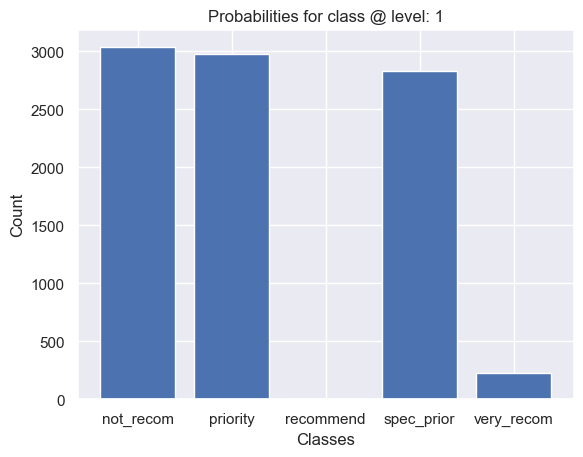

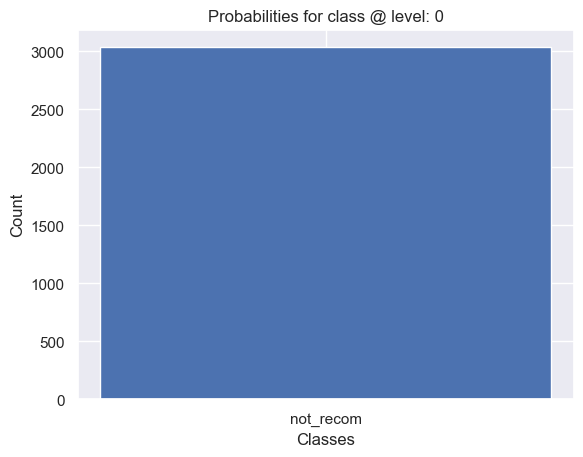

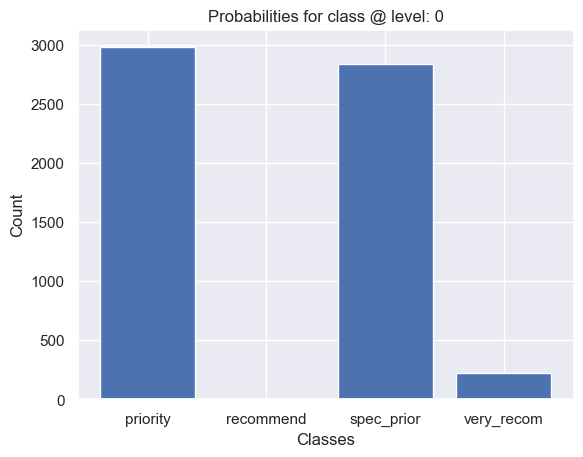

check for health == not_recom
True: 
Leaf Node: not_recom
False: 
Leaf Node: priority
Tree: <__main__.Node object at 0x1416a3940> 
 accuracy: 66.307%, CrossEntropyLoss: 0.411


***************************************


Decision Tree with Params: iDepth:4, informationGain:0.05, impurity_threshold:0.5


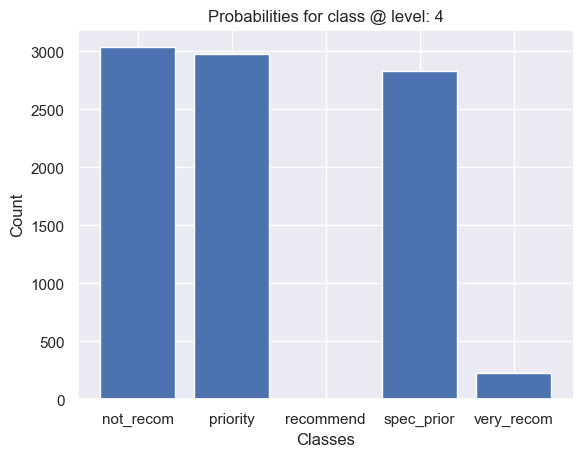

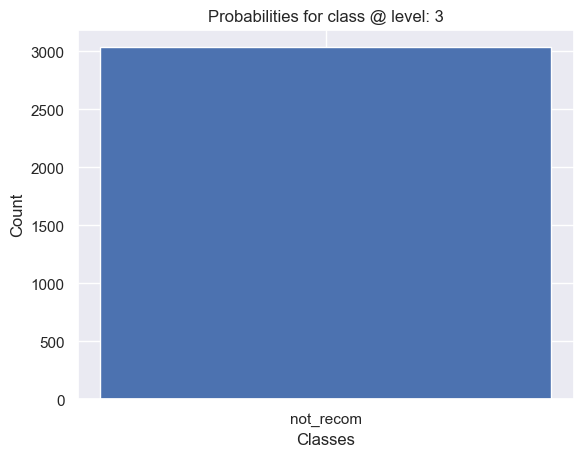

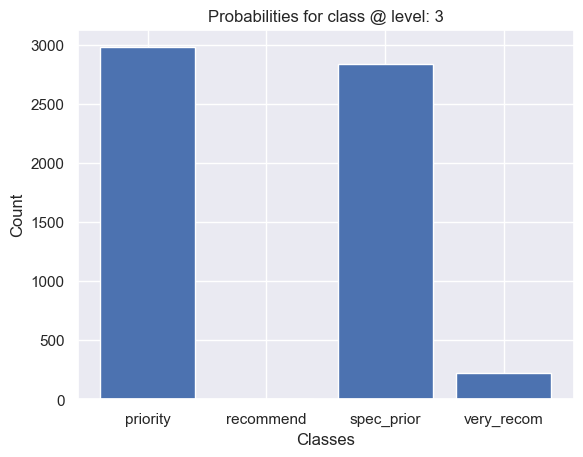

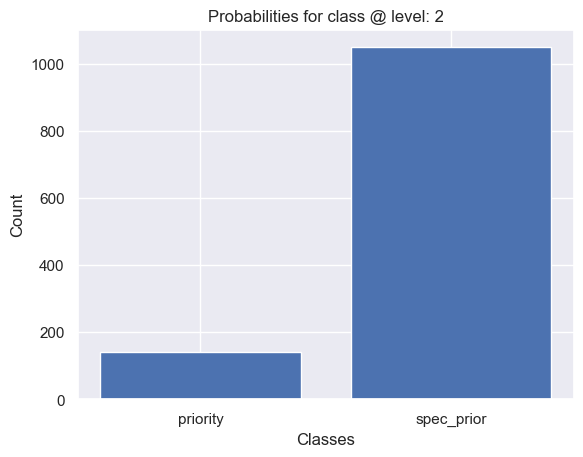

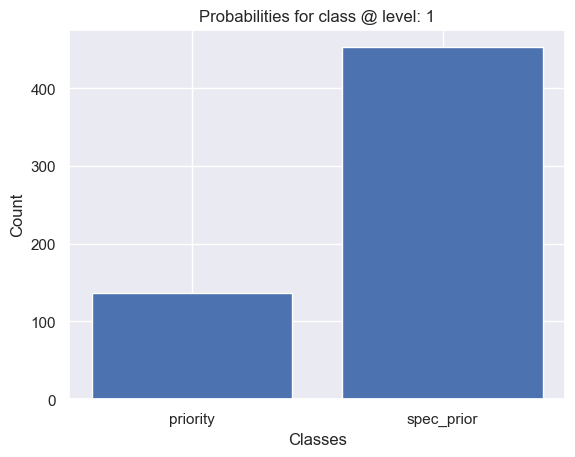

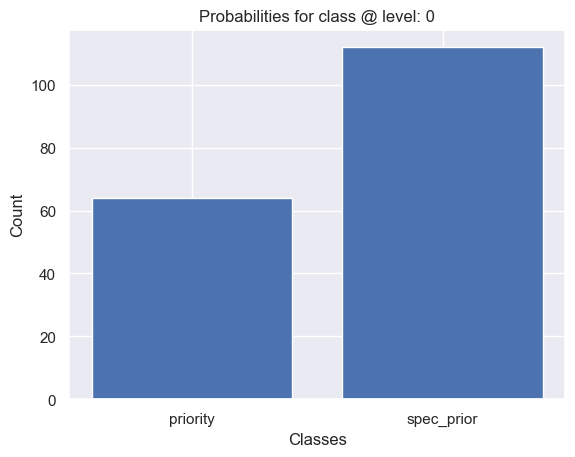

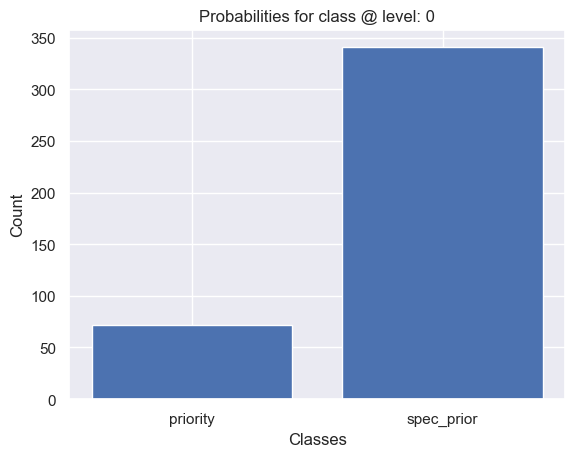

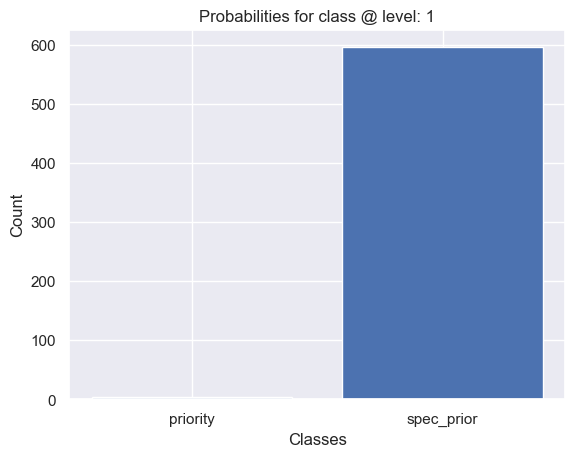

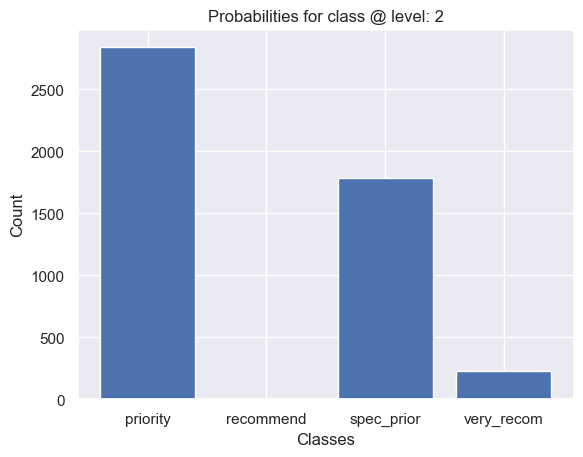

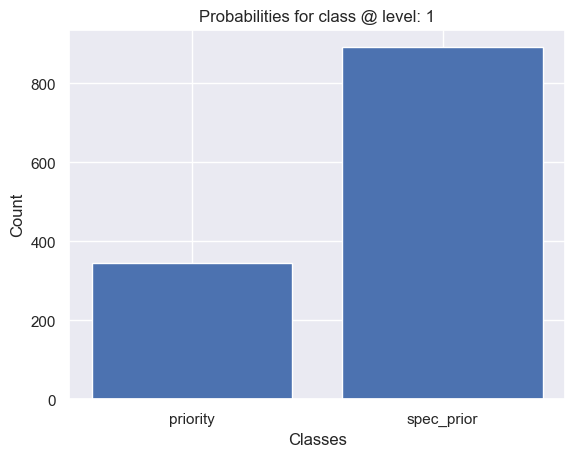

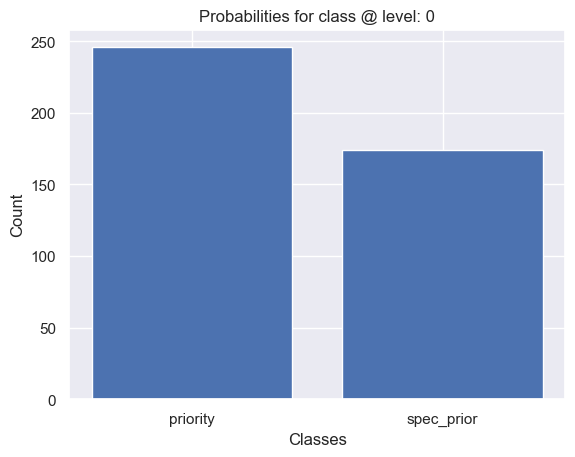

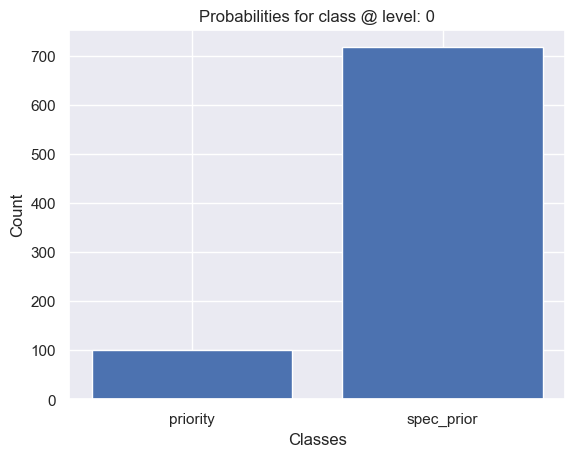

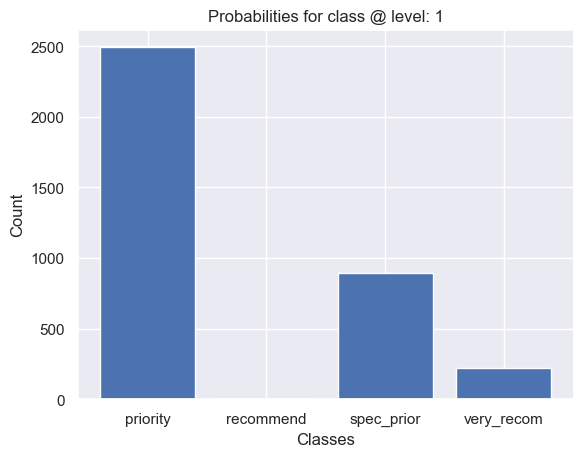

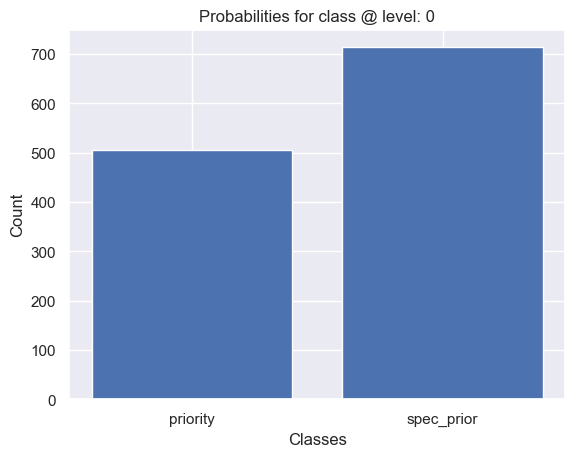

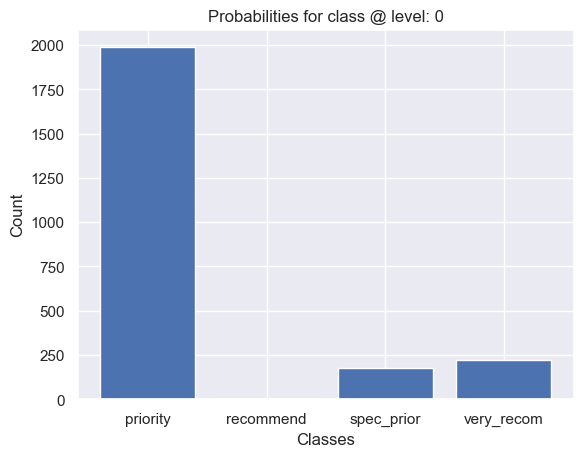

check for health == not_recom
True: 
Leaf Node: not_recom
False: 
check for has_nurs == very_crit
True: 
check for health == recommended
True: 
check for social == slightly_prob
True: 
Leaf Node: spec_prior
False: 
Leaf Node: spec_prior
False: 
Leaf Node: spec_prior
False: 
check for has_nurs == critical
True: 
check for parents == usual
True: 
Leaf Node: priority
False: 
Leaf Node: spec_prior
False: 
check for parents == great_pret
True: 
Leaf Node: spec_prior
False: 
Leaf Node: priority
Tree: <__main__.Node object at 0x14766dff0> 
 accuracy: 84.979%, CrossEntropyLoss: 0.163


***************************************


Decision Tree with Params: iDepth:6, informationGain:0.1, impurity_threshold:0.9


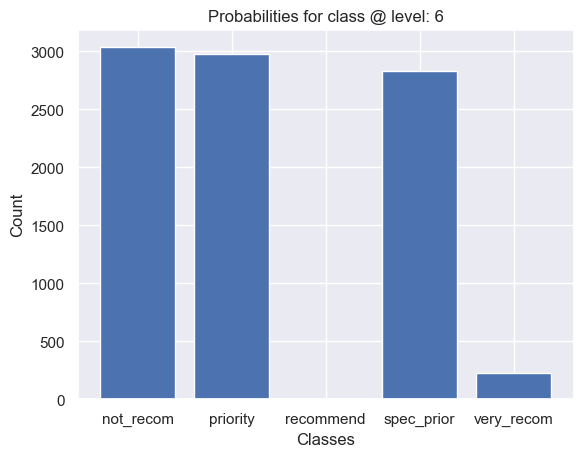

Leaf Node: not_recom
Tree: <__main__.Node object at 0x1476d0d00> 
 accuracy: 34.002%, CrossEntropyLoss: 1.079


In [56]:
"""Lists of parameters that will be used to train the decision tree model. 
These include the maximum depth of the tree iDepthlst, the minimum information gain 
required to split a node informationGainlst, and the minimum impurity threshold required 
to stop splitting a node impuritythresholdlst. For each combination of these parameters, 
the code prints a header indicating the parameter values being used, trains a decision tree 
model using the traindf data, the column names of the data colNames, the target column targetCol, 
and the evaluation metric mcr."""
for iDepth, iGain, iThresh in zip(iDepth_lst, informationGain_lst, impurity_threshold_lst):
    print('\n\n***************************************\n\n')
    print('Decision Tree with Params: iDepth:{}, informationGain:{}, impurity_threshold:{}'.format(iDepth, iGain, iThresh))
    root = decisionTreeLearn(train_df, colNames, targetCol, 'mcr' , iDepth, iThresh, iGain)
    treePrint(root)
    print('Tree: {} \n accuracy: {}%, CrossEntropyLoss: {}'.format(root, np.round(accuracy(root, val_df, targetCol)*100,3), np.round(-1 * np.log(accuracy(root, val_df, targetCol)), 3)))




***************************************


Decision Tree with Params: iDepth:1, informationGain:0.02, impurity_threshold:0.2


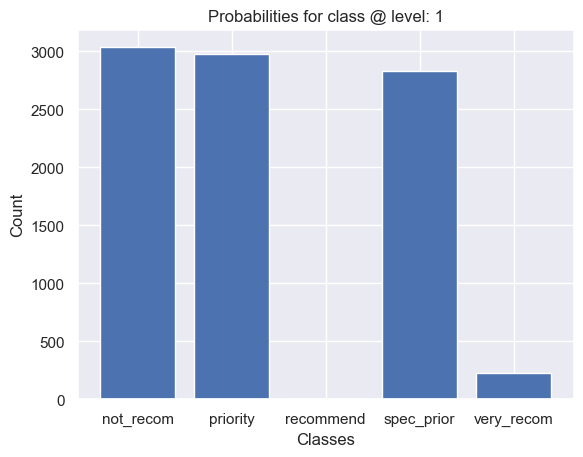

Leaf Node: not_recom
Tree: <__main__.Node object at 0x1476b3700> 
 accuracy: 34.002%, CrossEntropyLoss: 1.079


***************************************


Decision Tree with Params: iDepth:4, informationGain:0.05, impurity_threshold:0.5


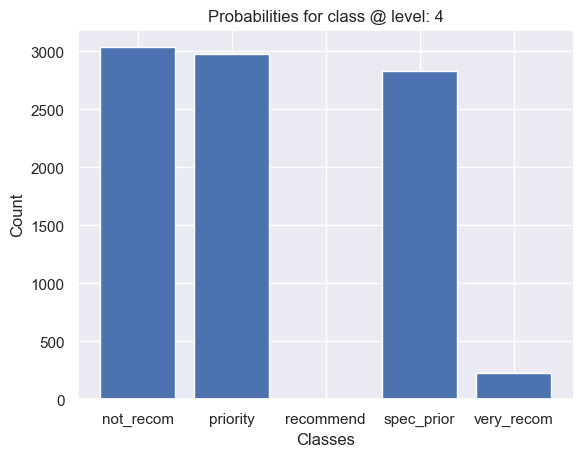

Leaf Node: not_recom
Tree: <__main__.Node object at 0x147754fa0> 
 accuracy: 34.002%, CrossEntropyLoss: 1.079


***************************************


Decision Tree with Params: iDepth:6, informationGain:0.1, impurity_threshold:0.9


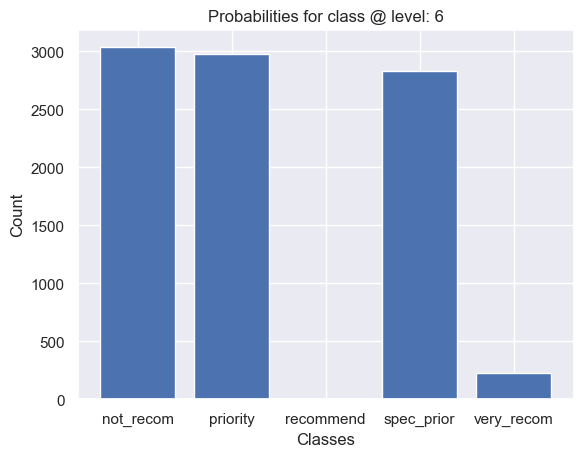

Leaf Node: not_recom
Tree: <__main__.Node object at 0x14168e350> 
 accuracy: 34.002%, CrossEntropyLoss: 1.079


In [57]:
"""Lists of parameters that will be used to train the decision tree model. 
These include the maximum depth of the tree iDepthlst, the minimum information gain 
required to split a node informationGainlst, and the minimum impurity threshold required 
to stop splitting a node impuritythresholdlst. For each combination of these parameters, 
the code prints a header indicating the parameter values being used, trains a decision tree 
model using the traindf data, the column names of the data colNames, the target column targetCol, 
and the evaluation metric 'gain'."""
for iDepth, iGain, iThresh in zip(iDepth_lst, informationGain_lst, impurity_threshold_lst):
    print('\n\n***************************************\n\n')
    print('Decision Tree with Params: iDepth:{}, informationGain:{}, impurity_threshold:{}'.format(iDepth, iGain, iThresh))
    root = decisionTreeLearn(train_df, colNames, targetCol, 'gain' , iDepth, iThresh, iGain)
    treePrint(root)
    print('Tree: {} \n accuracy: {}%, CrossEntropyLoss: {}'.format(root, np.round(accuracy(root, val_df, targetCol)*100,3), np.round(-1 * np.log(accuracy(root, val_df, targetCol)), 3)))